In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import random

# -------------------------------------------------------------------------------------------
# Mass Balance Environment
# -------------------------------------------------------------------------------------------

class MassBalanceEnv:
    """
    Mass balance environment:
    - Two sensors (A and B) measure mass.
    - Diversion reduces flow to B.
    - Detection occurs if total mass deviates from expected bounds.
    """
    
    diversion_actions = np.array([2.0, 1.75, 1.5, 1.0, 0.5, 0.1, 0.0], dtype=float)
    
    def __init__(self, diversion=0.0):
        """
        Initialize the environment. 
        """
        self.diversion = diversion
        self.max_diversion = 5.0
        self.time_limit = 100 # simulation run for 100 steps; a step = s > a, s', r, done
        self.detection_bounds = (86, 114)
        self.reset()

    def reset(self):
        """
        Start a new episode and return the first observation.
        """
        self.sensor_A = 100.0
        self.sensor_B = 0.0
        self.time = 0
        return self._observe()

    def _observe(self):
        """
        Return noise readings with platform cell's ITV
        """
        uncertainty_fraction = 0.0007 # 0.07% as decimal
        noisy_A = self.sensor_A * (1 + np.random.normal(0, uncertainty_fraction))
        noisy_B = self.sensor_B * (1 + np.random.normal(0, uncertainty_fraction))
        return np.array([noisy_A, noisy_B], dtype=np.float32)

    def step(self, diversion=None):
        """ 
        Advance one time step.
        """
        if diversion is not None:
            self.diversion = diversion
            
        flow = np.random.uniform(1.8, 2.2) 
        #flow = min(flow, self.sensor_A) #limit flow by what's available in A
        diverted = min(self.diversion, flow) #limit diversion by that flow
        self.sensor_A -= flow                 # mass leaves sensor A
        self.sensor_B += (flow - diverted)    # remaining mass goes to sensor B
        self.time += 1
        
        noisy_readings = self._observe()
        noisy_total = noisy_readings[0] + noisy_readings[1]

        detected = not (self.detection_bounds[0] <= noisy_total <= self.detection_bounds[1])

        total_mass = self.sensor_A + self.sensor_B
        
        # compute total mass after update
        done = self.time >= self.time_limit or detected or total_mass <= 0.0 #3a
        #done = self.time >= self.time_limit #1a
        #done = self.time >= self.time_limit or detected #2a

        #true_total = self.sensor_A + self.sensor_B #1b, 2b

        true_total = total_mass #3b

        # --- Identify termination reason ---
        # Helpful for tuning detection thresholds or flow ranges
        #termination_reason = None
        #if done:
            #if detected:
                #termination_reason = "DETECTION"
            #elif total_mass <= 0.0:
                #termination_reason = "MASS DEPLETION"
            #elif self.time >= self.time_limit:
                #termination_reason = "TIME LIMIT"

            #print(f"Episode ended at step {self.time} due to {termination_reason}")


        # -------------------

        #return self._observe(), detected, done, total_mass, diverted, termination_reason
        return self._observe(), detected, done, total_mass, diverted #3c
        #return self._observe(), detected, done, true_total, diverted #1c, 2c

In [24]:
# ----------------------------------------------------------------
# RL Components 
# ----------------------------------------------------------------

# ---- State representative ---
mass_bins = np.array([
    83.7, 84.7, 85.2, 85.6, 85.75, 85.8, 85.85, 85.9, 85.95, 
    86.0, 86.05, 86.1, 86.15, 86.2, 86.5, 87.0, 88.0, 90.0, 
    95.0, 97.0, 99.0, 102.0
], dtype=float)

bin_labels = [
    '83.7-84.7', '84.7-85.2', '85.2-85.6', '85.6-85.75', '85.75-85.8',
    '85.8-85.85', '85.85-85.9', '85.9-85.95', '85.95-86.0',
    '86.0-86.05', '86.05-86.1', '86.1-86.15', '86.15-86.2',
    '86.2-86.5', '86.5-87.0', '87.0-88.0', '88.0-90.0',
    '90.0-95.0', '95.0-97.0', '97.0-99.0', '99.0-102.0', '>102'
]
    
n_states = len(bin_labels) 

def total_mass_to_bin(noisy_total: float) -> int:
    """
    Map noisy total mass to a discrete bin index.
    """
    idx = np.digitize(noisy_total, mass_bins) - 1 # values >= last edge go to last bin index == len(MASS_BINS)
    idx = np.clip(idx, 0, len(bin_labels) - 1)
    return int(idx) 

# ---- Reward function ----
#def compute_reward(detected: bool, diverted: float, detection_penalty: float = 50.0) -> float:
    """
    Reward = diverted mass - penalty if detected.
    """
    #return float(diverted) - (detection_penalty if detected else 0.0)


# ---- Reward function (cumulative-aware shaping) ----
def compute_reward(sensor_A: float, sensor_B: float, diverted: float, detected: bool, 
                   lower_bound: float = 86.0, detection_penalty: float = 50.0) -> float:
    """
    Reward encourages diversion while considering risk over time.
    - Step-wise reward: diverted mass
    - Risk factor increases penalty as total mass approaches lower bound
    - Large penalty if detection occurs
    """
    total_mass = sensor_A + sensor_B
    safe_margin = 5.0  # adjustable: how close to lower_bound counts as risky
    risk_factor = max(0.0, 1.0 - (total_mass - lower_bound) / safe_margin)
    reward = diverted - risk_factor * detection_penalty
    if detected:
        reward -= detection_penalty  # large penalty for detection
    return float(reward)


# --- Epsilon-greedy policy ---

# With probability epsilon, picks a random action (exploration).
def epsilon_greedy_action(Q: np.ndarray, state: int, epsilon: float, n_actions: int) -> int:
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)  # random integer between 0 and n_actions-1
    return int(np.argmax(Q[state])) # finds the action with the highest Q-value fot that state.

In [25]:
# ---------------------------------------------
# Q-Learning Agent / Training
# ---------------------------------------------

def q_learning_train(
    episodes: int = 500,
    alpha: float = 0.2,
    gamma: float = 0.95,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.05,
    epsilon_decay: float = 0.995,
    detection_penalty: float = 50.0,
    early_terminate_on_detection: bool = False,
    seed: int | None = 42
):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # --- actions ----
    actions = MassBalanceEnv.diversion_actions
    n_actions = len(actions)
    n_states = len(bin_labels)
    
    Q = np.zeros((n_states, n_actions))
    eps = epsilon_start

    # Logs
    episode_rewards = []
    episode_detections = []
    episode_lengths = []
    visit_counts = np.zeros((n_states, n_actions), dtype=int)

    for ep in range(episodes):
        env = MassBalanceEnv()
        obs = env.reset()
        s = total_mass_to_bin(float(obs[0] + obs[1]))

        done = False
        total_reward = 0.0
        detected_any = False
        steps = 0

        while not done:
            a = epsilon_greedy_action(Q, s, eps, n_actions)
            diversion = float(actions[a])
            obs_next, detected, done, true_total, diverted = env.step(diversion)
            #reward = compute_reward(detected, diverted, detection_penalty) #1d, 2d
            reward = compute_reward(
                env.sensor_A, 
                env.sensor_B, 
                diverted, 
                detected, 
                detection_penalty=detection_penalty 
            ) #3d

            # Record visit
            visit_counts[s, a] += 1

            # Compute next state
            s_next = total_mass_to_bin(float(obs_next[0] + obs_next[1]))

            # Q-learning update
            Q[s, a] += alpha * (reward + gamma * np.max(Q[s_next]) - Q[s, a])

            s = s_next
            total_reward += reward
            detected_any = detected_any or detected
            steps += 1

            if early_terminate_on_detection and detected:
                break

        eps = max(epsilon_end, eps * epsilon_decay)
        episode_rewards.append(total_reward)
        episode_detections.append(detected_any)
        episode_lengths.append(steps)

    return Q, {
    "episode_rewards": episode_rewards,
    "episode_detections": episode_detections,
    "episode_lengths": episode_lengths,
    "visit_counts": visit_counts
}

In [26]:
# ----------------------------------------
# Policy extraction & evaluation
# ----------------------------------------

# --- Derive greedy policy from Q ---
def greedy_policy_from_Q(Q: np.ndarray) -> np.ndarray:
    
    return np.argmax(Q, axis=1) # finds the index of the max action-value for each state
    

# --- Evaluate a fixed policy ---
def evaluate_policy(
    policy_actions: np.ndarray, 
    episodes: int = 100, 
    detection_penalty: float = 50.0, 
    seed: int | None = 123,
    early_terminate_on_detection: bool = False
):

    # Set random seeds for reproducibility
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Lists to record results for each episode
    rewards, detections, lengths = [], [], []

    # Run multiple episodes
    for _ in range(episodes):
        env = MassBalanceEnv()
        obs = env.reset()
        done = False
        ep_reward = 0.0
        ep_detected = False
        steps = 0

        # Run until the episode is finished
        while not done:
            # Convert observation to a discrete state
            noisy_total = float(obs[0] + obs[1]) 
            s = total_mass_to_bin(noisy_total)

            # Select the greedy action for this state
            a = int(policy_actions[s])
            diversion = float(MassBalanceEnv.diversion_actions[a])

            obs, detected, done, total, diverted = env.step(diversion=diversion)

            #reward = compute_reward(detected, diverted, detection_penalty) # computes reward
            #r = compute_reward(detected, diverted, detection_penalty) # computes reward, 1e, 2e
            r = compute_reward(
                env.sensor_A,   # current mass in sensor A
                env.sensor_B,   # current mass in sensor B
                diverted,       # mass diverted this step
                detected,       # whether detection occurred
                detection_penalty=detection_penalty
            ) #3e

            
            # updates episode totals
            ep_reward += r
            ep_detected = ep_detected or detected
            steps += 1

            # --- Early termination ---
            """
            Add evaluation with early termination.
            Stop episode when detected to avoid huge negative rewards.
            """
            if early_terminate_on_detection and detected:
                done = True

        # save results of this episode
        rewards.append(ep_reward)
        detections.append(ep_detected)
        lengths.append(steps)

    return {
        "mean_reward": float(np.mean(rewards)), # average reward
        "std_reward": float(np.std(rewards)), # variability in rewards
        "detection_rate": float(np.mean(detections)), # fraction of episodes caught
        "avg_length": float(np.mean(lengths)), # average number of steps
        "rewards": np.array(rewards), # store raw rewards
    }



Q-matrix (state-action values):
                             2.00        1.75        1.50        1.00  \
State 0 (83.7-84.7)      0.000000    0.000000    0.000000    0.000000   
State 1 (84.7-85.2)      0.000000    0.000000    0.000000    0.000000   
State 2 (85.2-85.6)      0.000000    0.000000    0.000000    0.000000   
State 3 (85.6-85.75)     0.000000    0.000000    0.000000    0.000000   
State 4 (85.75-85.8)   -23.735943  -23.550000    0.000000    0.000000   
State 5 (85.8-85.85)   -23.542461    0.000000    0.000000    0.000000   
State 6 (85.85-85.9)   -23.569714  -23.332292  -22.799066  -21.731124   
State 7 (85.9-85.95)   -56.685504  -56.673311  -55.367183  -52.877793   
State 8 (85.95-86.0)   -69.047170  -68.065427  -66.928527  -64.019667   
State 9 (86.0-86.05)   -97.455195  -95.707976  -94.055631  -93.931481   
State 10 (86.05-86.1) -100.879833  -99.637763 -100.269933  -98.979914   
State 11 (86.1-86.15) -100.836278 -102.396552 -102.564476 -101.662454   
State 12 (86.15-86

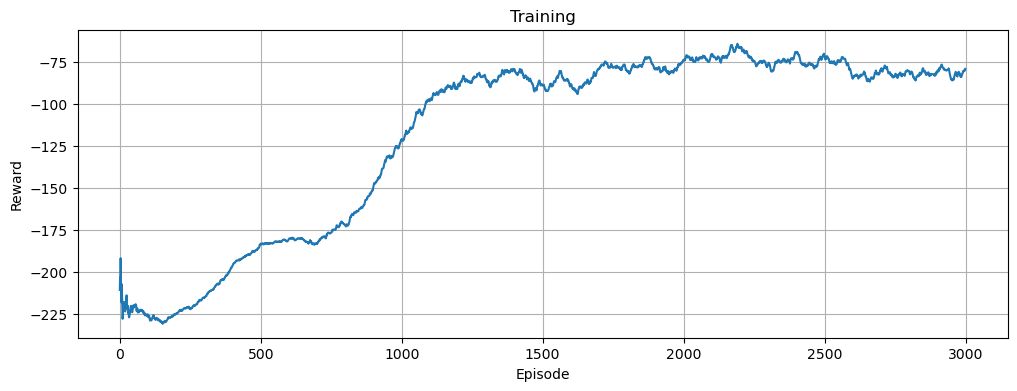

Training detection rate (episodes with any detection): 0.590

Evaluation of learned greedy policy:
  Mean episode reward: 3.70 ± 0.06
  Detection rate: 0.000
  Avg episode length: 100.0 steps


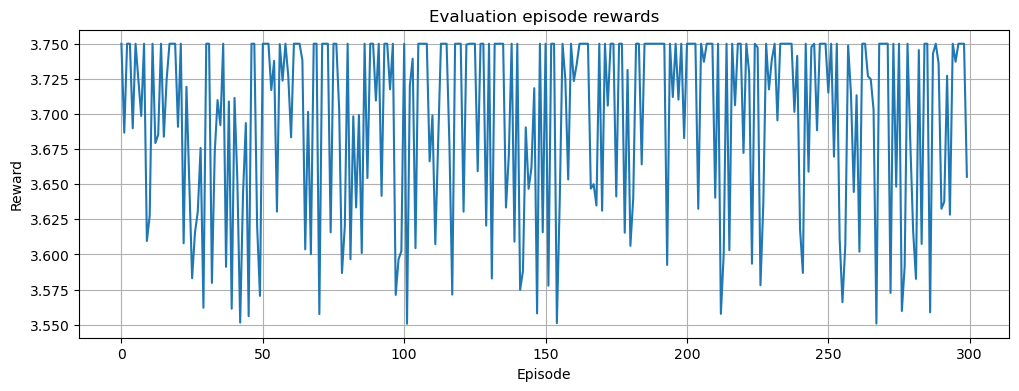

In [27]:
# --------------------------
# Run training and results
# --------------------------

episodes = 3000 # how many episodes to train for; started with 1500, 3000 for more exploration
alpha = 0.2 # learning rate (how fast Q-values are updated); faster learning 
gamma = 0.95  # discount factor (importance of future rewards); larger helps agent plan ahead better 
eps_start = 1.0 # initial exploration rate (100% random at start, and pure exploration)
eps_end = 0.05 # minimum exploration (5% random, and mostly exploitation) 
eps_decay = 0.997  # how quickly exploration decreases
detection_penalty = 50  # higher means more cautious agent
early_term_on_det = True   # end episode when detected

# --- Train the Q-learning agent ---
Q, logs = q_learning_train(
    episodes=episodes,
    alpha=alpha,
    gamma=gamma,
    epsilon_start=eps_start,
    epsilon_end=eps_end,
    epsilon_decay=eps_decay,
    detection_penalty=detection_penalty,
    early_terminate_on_detection=early_term_on_det,
    seed=42
)

df_Q = pd.DataFrame(
    Q, 
    index=[f"State {i} ({bin_labels[i]})" for i in range(n_states)], 
    columns=[f"{a:.2f}" for a in MassBalanceEnv.diversion_actions]
)
print("\nQ-matrix (state-action values):")
print(df_Q)

# --- Print state–action visit counts ---
print("\nState–Action Visit Counts:")
df_visits = pd.DataFrame(
    logs["visit_counts"], 
    index=[f"State {i} ({bin_labels[i]})" for i in range(n_states)],
    columns=[f"{a:.2f}" for a in MassBalanceEnv.diversion_actions]
)
print(df_visits)

# Highlight unvisited pairs
unvisited = np.argwhere(df_visits.values == 0)

for s, a in unvisited:
    print(f"  {df_visits.index[s]}, Action {df_visits.columns[a]}")


# --- Derive the greedy policy from Q ---
policy_actions = greedy_policy_from_Q(Q)  # best action index per state

# tells you how much to divert in each bun to maximize reward while avoiding detection

# convert to actual diversion values
policy_diversions = MassBalanceEnv.diversion_actions[policy_actions]  


# Print learned policy in a readable form
print("\nLearned greedy policy by mass bin:")
for i, div in enumerate(policy_diversions):
    print(f"  State bin {i:>2} ({bin_labels[i]}): diversion {div} g/s")
    

# --- Plot training curve (smoothed rewards) ---
plt.figure(figsize=(12,4))
plt.plot(pd.Series(logs["episode_rewards"]).rolling(250, min_periods=1).mean())
plt.title("Training") #: window=25
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Training detection rate (fraction of episodes where agent was caught)
det_rate_train = float(np.mean(logs["episode_detections"]))
print(f"Training detection rate (episodes with any detection): {det_rate_train:.3f}")

# --- Evaluate learned policy (no more exploration, just greedy actions) ---
eval_stats = evaluate_policy(
    policy_actions, 
    episodes=300, 
    detection_penalty=detection_penalty, 
    seed=7,
    early_terminate_on_detection=True # enables early termination
)

print("\nEvaluation of learned greedy policy:")
print(f"  Mean episode reward: {eval_stats['mean_reward']:.2f} ± {eval_stats['std_reward']:.2f}")
print(f"  Detection rate: {eval_stats['detection_rate']:.3f}")
print(f"  Avg episode length: {eval_stats['avg_length']:.1f} steps")

# --- Plot evaluation rewards ---
plt.figure(figsize=(12,4))
plt.plot(eval_stats["rewards"])
plt.title("Evaluation episode rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()